# Exercises Week 11-12: Graded exercise session (part A)

**Course**: [Life Sciences engineering: genome to function](https://go.epfl.ch/BIO-411) (BIO-411)

**Professors**:  _Gönczy Pierre_, _Naef Felix_, _McCabe Brian Donal_

SSV, MA, 2023-2024


**Group 26**: Gian Maria Velardi, Viola Renne, Theo Lacroix, Meline Cretegny

In [1]:
#import librairies
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, nbinom, skew
from scipy.integrate import odeint
from scipy.special import gammaln, digamma, polygamma
import statsmodels.api as sm


**Provide answers in the form of code, figures (if relevant) and short descriptions (in markdown cells) in those notebooks. Submit your notebook to Moodle, please make sure to execute every cell.**

## Exercise 1: Transcriptional bursting

Let's consider the transcriptional process in which an mRNA $x$ is produced at a rate $s$ and degraded at a rate $k$. In addition to the simple birth-death process that we simulated in week 10, we will now consider a two-state model for the promoter (Random Telegraph process). This means that the promoter can switch from an active ($g=1$) to inactive state ($g=0$) and vice-versa with respective rates $k_{off}$ and $k_{on}$.


The Telegraph process has the following elementary reactions:  
\begin{array}{lll}
(1, n) \longrightarrow (1, n+1) \textrm{ with rate } s \\
(g, n) \longrightarrow (g, n-1) \textrm{ with rate } kn \\
(1, n) \longrightarrow (0, n) \textrm{ with rate } k_{off} \\
(0, n) \longrightarrow (1, n) \textrm{ with rate } k_{on}
\end{array}

We describe the states $(g, n)$ with $g\in \{1, 0\}$, $n \in \mathbb{N}$.

### Question 1
1. Using the code template provided, which includes initial values and parameters, modify the Gillespie algorithm to simulate the Telegraph model. Focus on integrating the two-state model for the promoter accurately into the algorithm. You can refer to the Gillespie function from *Exercise week 10* as a starting point.

2. Systematically vary the rates (e.g increase or decrease $k$, $s$, $k_{on}$, $k_{off}$), plot representative traces and comment. Find cases that show qualitatively different behaviors.

#### Question 1.1

**Question 1.1**  

The modification we did to the simulation of Telegraph model involves the state matrix, which needs to include whether the system is currently in a state with the promoter ON or OFF.
When the promoter is ON, there are three possible state changes:
- The promoter remains ON, allowing synthesis at a rate of s ([0, 1]).
- The promoter remains ON, leading to degradation at a rate of $kn$ ([0, -1]).
- The promoter switches OFF with a rate of $k_{off}$ ([-1, 0]).

When the promoter is OFF, there are two potential state changes:
- The promoter remains OFF, and degradation occurs at a rate of $kn$ ([0, -1]).
- The promoter switches ON with a rate of $k_{on}$ ([1, 0]).

In [2]:
def run_gillespie_telegraph(n0, g0, parameters, t_end, DT):
    """
    Simulates the Random telepgrah process using the Gillespie algorithm.

    Parameters:
    n0 : Initial count of species n.
    g0 : Initial promoter state g (0 or 1).
    parameters: Tuple containing transcription rate s, degradation rate k, switching rates k_on and k_off
    t_end : Total simulation time.
    DT: time interval for returning/printing the output

    Returns:
    n_print : Trajectory of species n counts over time.
    g_print : Trajectory of promoter state g over time.
    t_print : Time points for each recorded reaction.
    """
    # Initialize state variables and time
    n = n0   
    g = g0   
    t = 0    
    tp = 0  

    # Initialize output lists
    n_print=[]  
    g_print=[]  
    t_print=[]  

    # Unpack parameters
    s, k, k_on, k_off = parameters 

    while t < t_end: 
        
        # Define state change matrix S and rate vector depending on promoter state
        if g == 1: # Promoter is active 
            S = np.array([[0, 1], [0,-1], [-1,0]])
            rates = [s, k*n, k_off]
        else: # Promoter is inactive
            S = np.array([[1, 0] , [0 , -1]])
            rates = [k_on, k*n]

        # Calculate total rate and sample time to next reaction
        rates_tot = sum(rates)
        dt = np.random.exponential(scale=1.0 / rates_tot)
        t += dt

        # Determine which reaction occurs next
        rand = np.random.random()        
        rates_cumsum = np.cumsum(rates)/rates_tot

        i=0
        while rand >= rates_cumsum[i]:
            i=i+1

        # Record output at specified DT intervals (equally spaced output)
        while tp < t and t <= t_end:
            n_print.append(n)
            g_print.append(g)
            t_print.append(tp)
            tp += DT
        # Update species n counts and promoter state g
        chosen_react=i
        g += S[chosen_react,0]
        n += S[chosen_react,1]
 

    return n_print, g_print, t_print

In [3]:
def plot_gillespie_telegraph(n, g, t):
    """
    Plots the Random telepgrah process using the Gillespie algorithm.

    Parameters:
    n: Species n counts over time.
    g: Promoter state g over time.
    t: Time points for each recorded reaction.

    """

    fig, axs = plt.subplots(2, figsize=(15, 5), sharex=True)

    # Plotting the number of molecules n over time
    axs[0].plot(t, n, label = 'n(t)', color='darkblue')
    axs[0].set_ylabel('# molecules n')

    # Plotting the promoter activity over time
    axs[1].vlines(x=t, ymin=0, ymax=np.array(g), colors='teal', lw=2, label='promoter activity')
    axs[1].set_ylim(0, 1.1)  # Set y-limits to make the promoter states clear (0 and 1)
    axs[1].set_ylabel('Promoter State')
    
    # Common x-label
    plt.xlabel('time')
    
    plt.show()

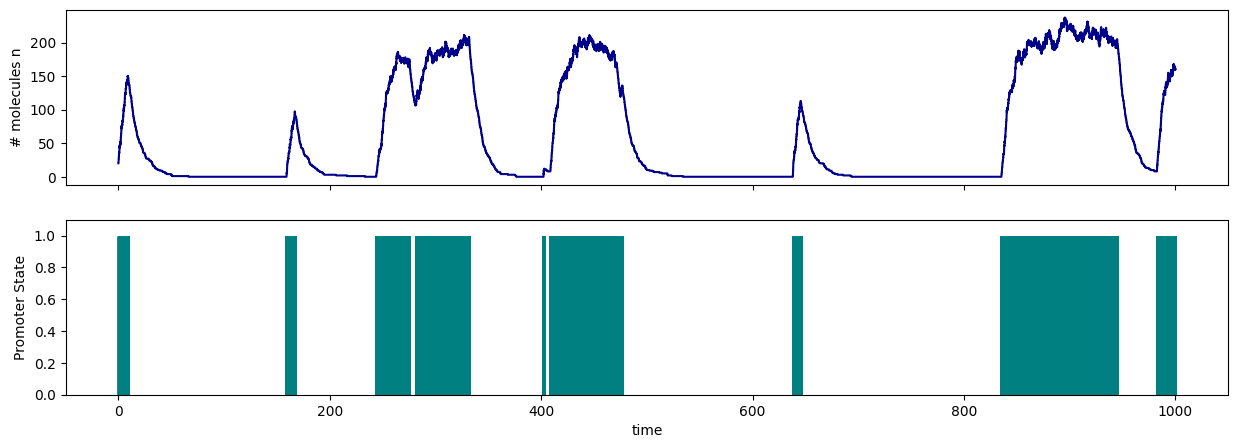

In [4]:
#initial conditions for the state (g,n) at time t=0
g_0 = 1 # Initial promoter state
n_0 = 20 # Initial count of species n

DT = 0.01 # Time interval for returning/printing the output
t_end = 1000 #Total simulation time in minutes

#Parameters
s = 20 # Number of initiations per minute
k = 1/10 # Degradation rate, 1/k = 10 min
k_off = 1/25 # Switching off rate, t_on = 1/k_off = 25 min
k_on  = 1/120 # Switching on rate, t_off = 1/k_on = 120 min

parameters = [s, k, k_on, k_off]

# Run Gillespie simulation
n, g, t = run_gillespie_telegraph(n_0, g_0, parameters, t_end, DT)

# Plot the results
plot_gillespie_telegraph(n, g, t)


#### Question 1.2

The behavior of the Random Telegraph algorithm can be examined by modifying its parameters.

In [5]:
# Helper Function, plots an histogram of n distribution
def plot_histogram(n):
    """
    Plots the distribution of data n with a superimposed Poisson distribution.

    Parameters:
    n: Array of counts (data from Gillespie simulation).
    """
    # Calculate histogram of n
    counts, bins = np.histogram(n, bins=range(min(n), max(n) + 2), density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])

    # Estimate lambda for Poisson distribution (mean of n)
    lam = np.mean(n)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(bin_centers, counts, width=0.8, color='gray', label='Empirical Distribution of n')

    plt.xlabel('n counts')
    plt.ylabel('Probability')
    plt.title('Empirical Distribution')
    plt.legend()
    plt.show()

##### Varying s 

We start by varying the synthesis rate (s), representing the "number of initiations per minute." 
The examples below illustrate two distinct and extreme cases: s=50 and s=1.

As s is involved in the reaction:

\begin{array}{lll}
(1, n) \longrightarrow (1, n+1) \textrm{ with rate } s \\
\end{array}

Our expectation is that a higher parameter value for s will result in an increased mean of n (species n counts).
This indicates a greater concentration of mRNA before the onset of the decay process, governed by the rate k*n.


The value of s is 50


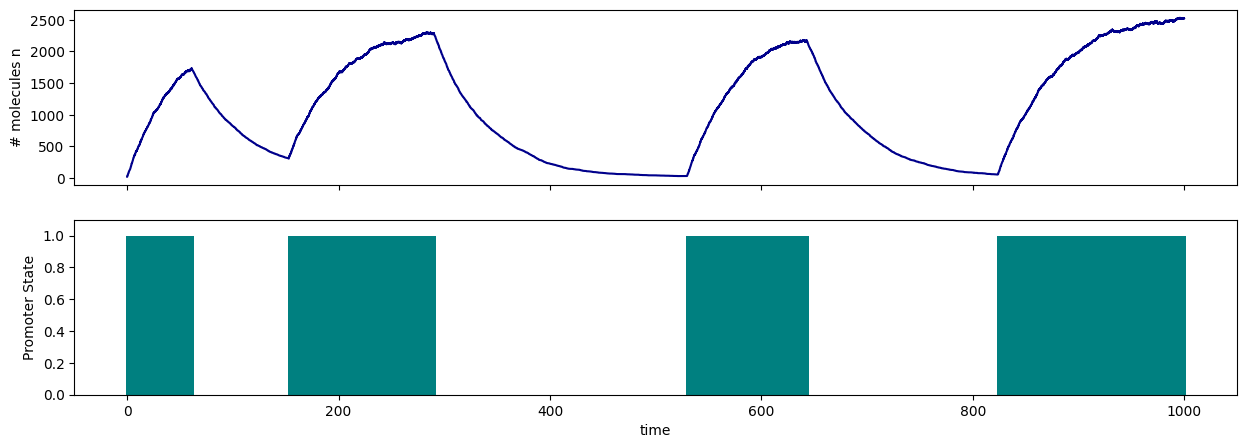

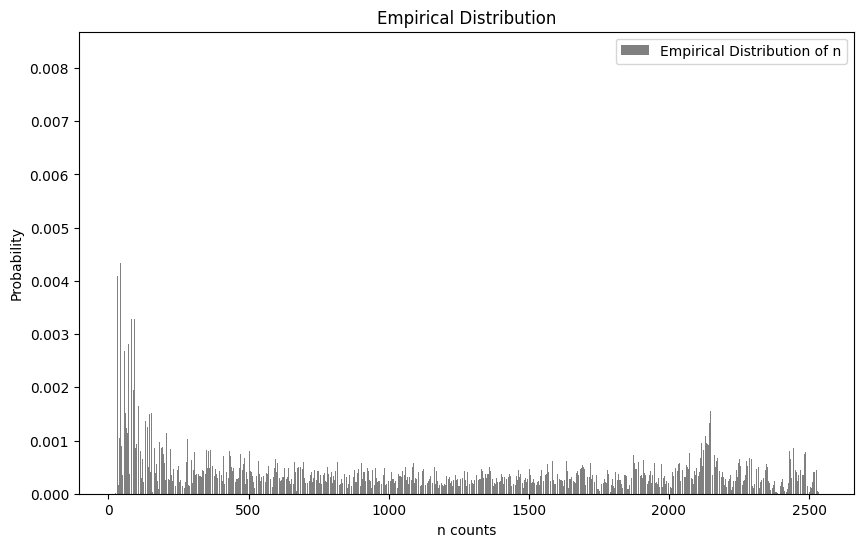

The value of s is 1


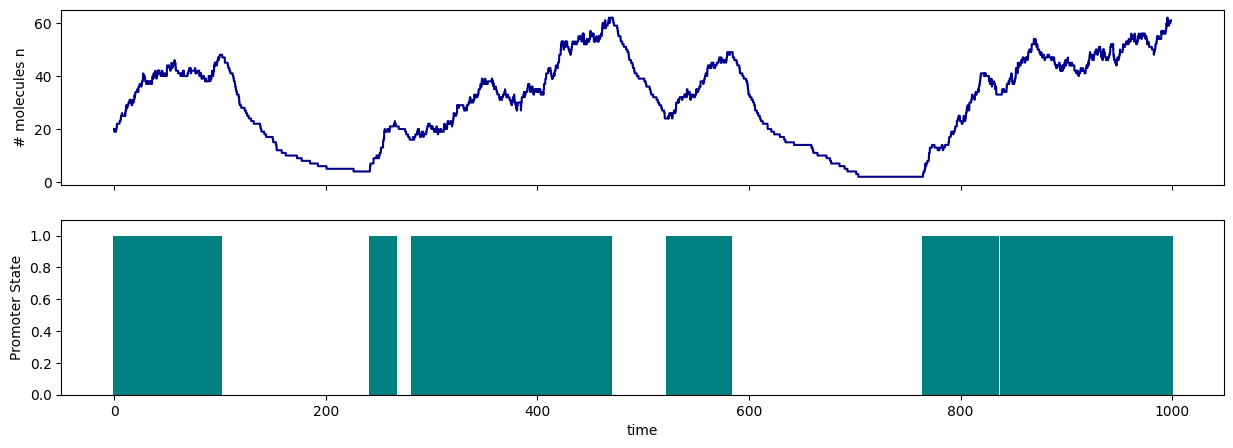

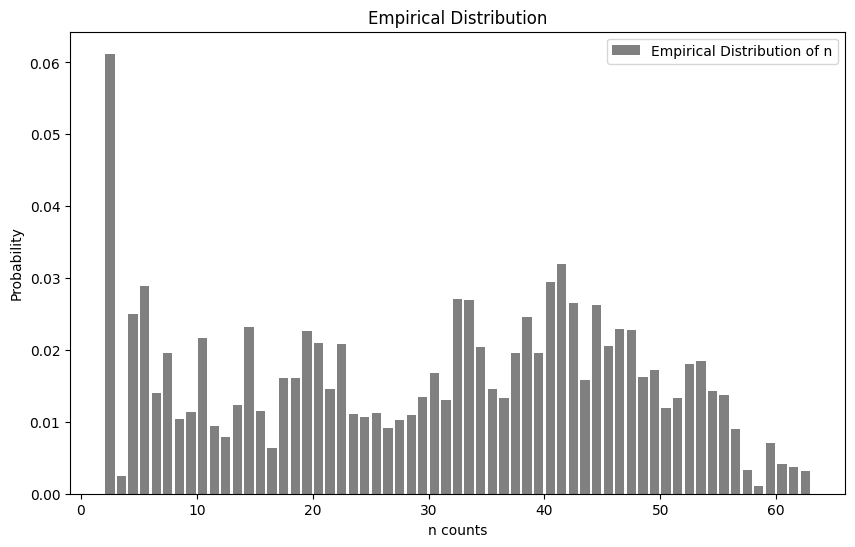

In [6]:
'''
When s = 50:
Given the intial parameters, we expect a greater value of mean n than before.
When s = 1:
Given the initial parameters, we expect a lower value of mean n than before.

k_off has been reduced to highlight the effects of a greater s on the birth death process described by the first two equations
'''

# Initial conditions for the state (g,n) at time t=0
g_0 = 1 # Initial promoter state
n_0 = 20 # Initial count of species n

DT = 0.01 # Time interval for returning/printing the output
t_end = 1000 #Total simulation time in minutes

# Parameters
s_values = [50, 1]  # Number of initiations per minute
k = 1/50 # Degradation rate, 1/k = 50 min
k_off = 1/150 # Switching off rate, t_on = 1/k_off = 150 min
k_on  = 1/120 # Switching on rate, t_off = 1/k_on = 120 min

for s in s_values:
    print(f'The value of s is {s}')
    parameters = [s, k, k_on, k_off]

    # Run Gillespie simulation
    n, g, t = run_gillespie_telegraph(n_0, g_0, parameters, t_end, DT)

    # Plot the results
    plot_gillespie_telegraph(n, g, t)
    plot_histogram(n)

It is possible to see that with s = 50, the maximum value for n is around 2500, while when s = 1, the maximum value for n is around 60.

##### Varying k 

We proceed to vary the degradation rate (k), examining its interaction with the synthesis rate (s).
Considering the set of equations:

\begin{array}{lll}
(1, n) \longrightarrow (1, n+1) \textrm{ with rate } s \\
(g, n) \longrightarrow (g, n-1) \textrm{ with rate } kn \\
\end{array}

We studied two cases we studied: k = 0.01 and k = 0.1

As the degradation rate (k) increases, we anticipate a faster decay process.

The value of k is 0.01


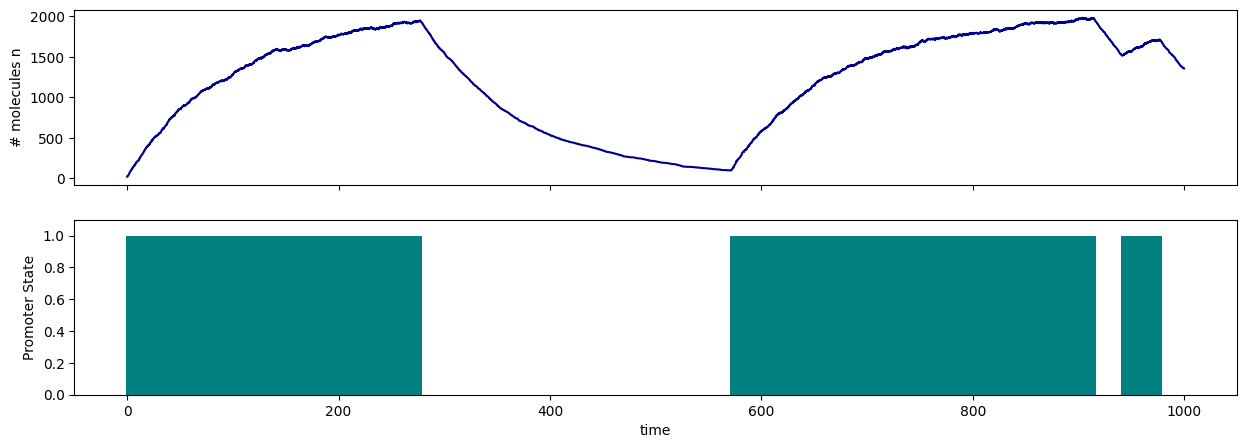

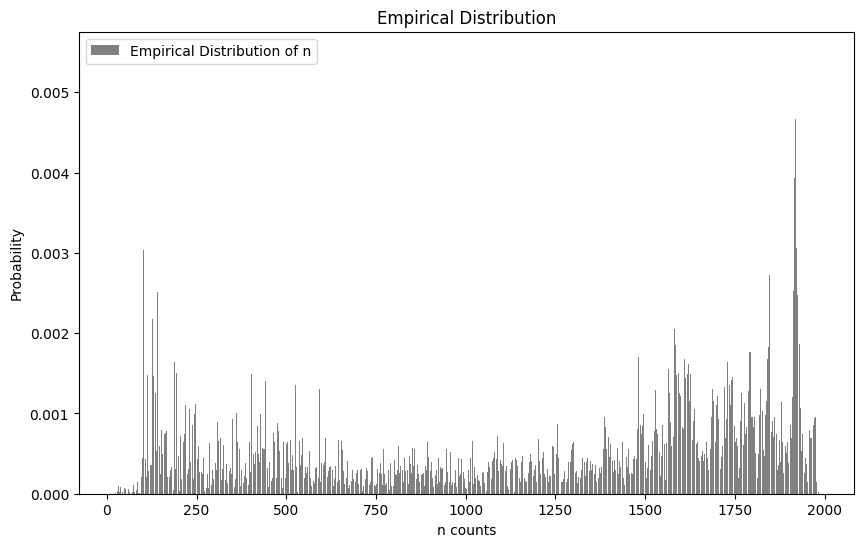

The value of k is 0.1


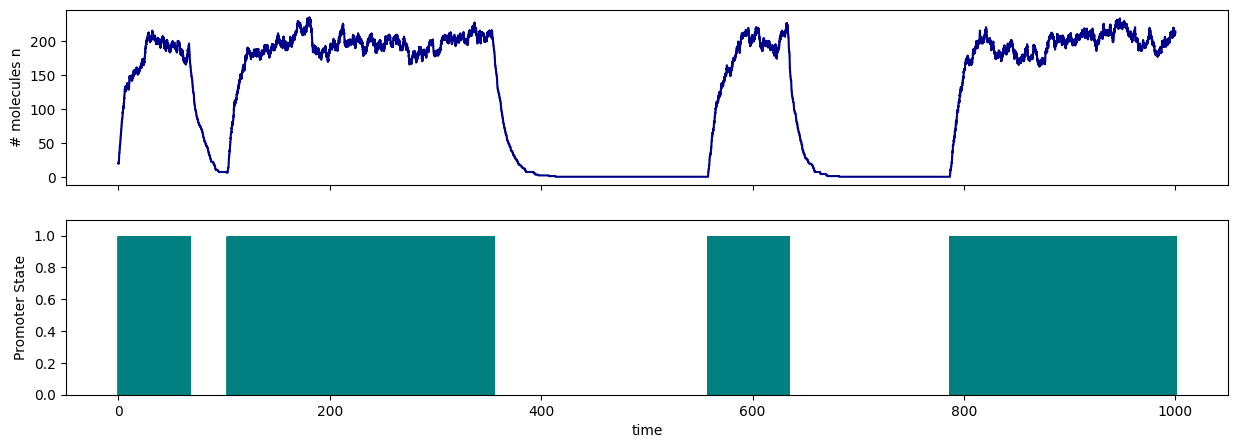

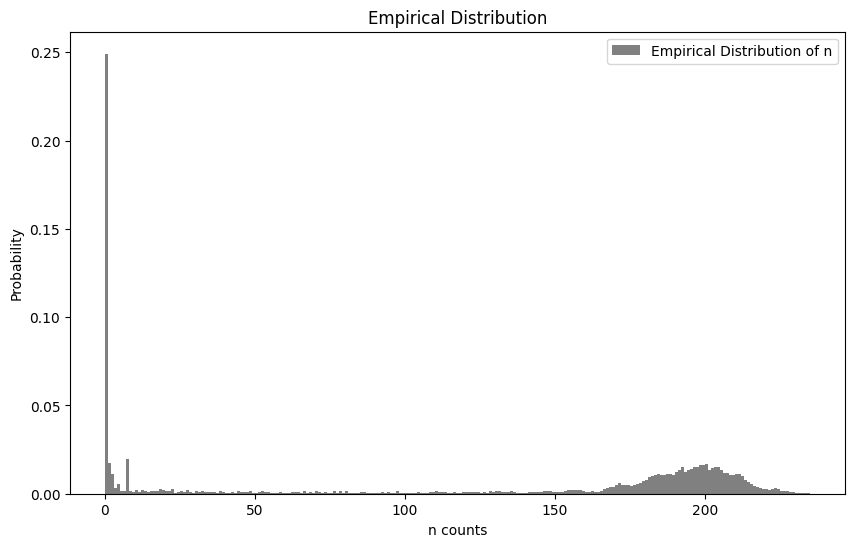

In [7]:
# Initial conditions for the state (g,n) at time t=0
g_0 = 1 # Initial promoter state
n_0 = 20 # Initial count of species n

DT = 0.01 # Time interval for returning/printing the output
t_end = 1000 #Total simulation time in minutes

#Parameters
s = 20 # Number of initiations per minute
k_values = [0.01, 0.1] # Degradation rate, 1/k = 100 min and 1/k = 10 min
k_off = 1/150 # Switching off rate, t_on = 1/k_off = 150 min
k_on  = 1/120 # Switching on rate, t_off = 1/k_on = 120 min

for k in k_values:
    print(f'The value of k is {k}')
    parameters = [s, k, k_on, k_off]

    # Run Gillespie simulation
    n, g, t = run_gillespie_telegraph(n_0, g_0, parameters, t_end, DT)

    # Plot the results
    plot_gillespie_telegraph(n, g, t)
    plot_histogram(n)

As anticipated, an increase in the degradation rate (k) leads to a faster decay process. When k is set to 0.01, the degradation is so slow that n is unable to reach state 0 before the synthesis restarts, as the decay process takes too long. Additionally, it's noted that as the degradation rate increases, the maximum number of n (mRNAs) decreases.

These last two experiments are just to show that as k increases, the steepness of the descending decay curve increases.
The synthesis rate, s, has no relation with the steepness of the curve.

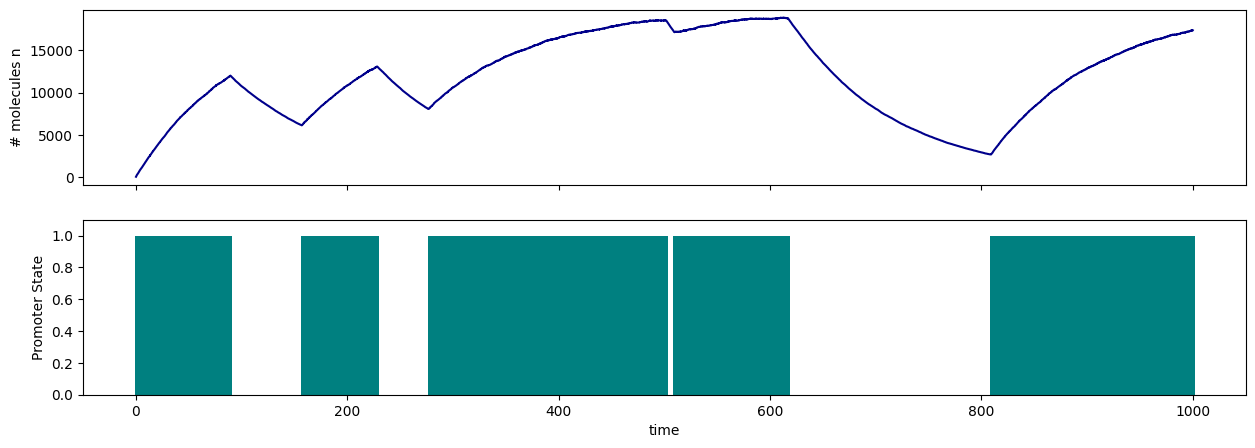

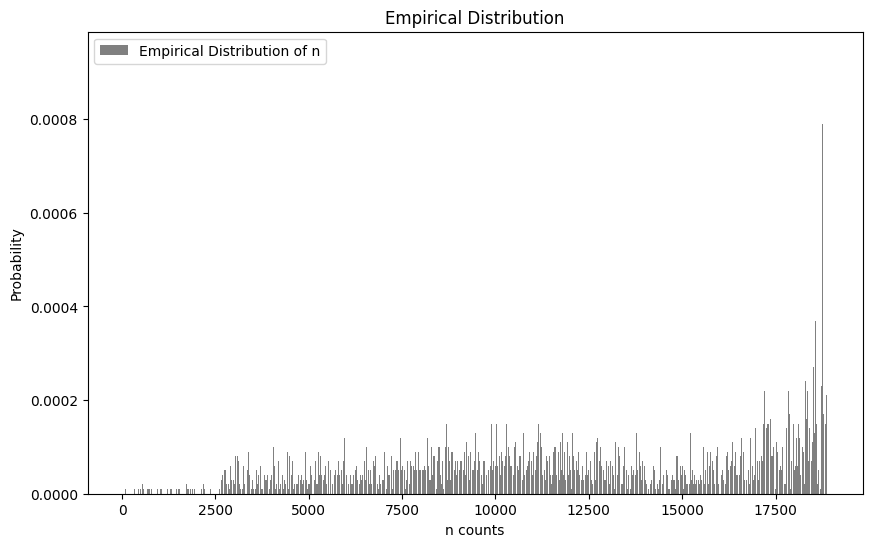

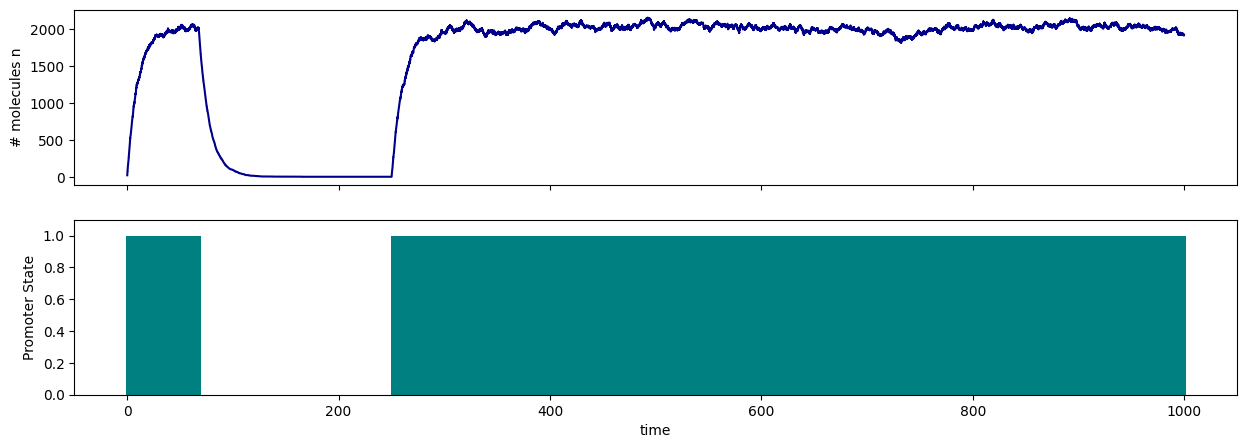

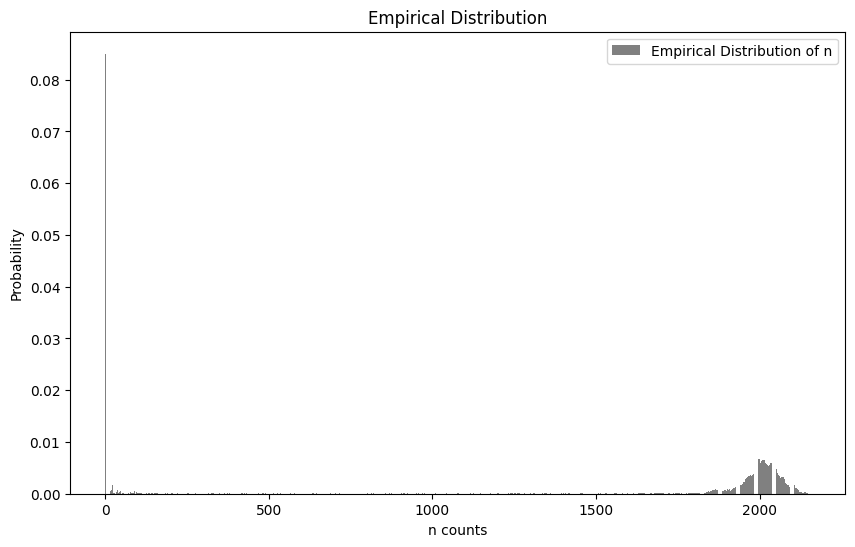

In [8]:
# Initial conditions for the state (g,n) at time t=0
g_0 = 1 # Initial promoter state
n_0 = 20 # Initial count of species n

DT = 0.01 # Time interval for returning/printing the output
t_end = 1000 #Total simulation time in minutes

#Parameters
s = 200 # Number of initiations per minute
k_values = [0.01, 0.1] # Degradation rate, 1/k = 100 min and 1/k = 10 min
k_off = 1/150 # Switching off rate, t_on = 1/k_off = 150 min
k_on  = 1/120 # Switching on rate, t_off = 1/k_on = 120 min

for k in k_values:
    parameters = [s, k, k_on, k_off]

    # Run Gillespie simulation
    n, g, t = run_gillespie_telegraph(n_0, g_0, parameters, t_end, DT)

    # Plot the results
    plot_gillespie_telegraph(n, g, t)
    plot_histogram(n)

##### Varying k_on and k_off 

Differently from the earlier parameters, k_on and k_off play a role not in the birth-death process of mRNA but in the activation of the promoter gene.

When both $k_{off}$ and $k_{on}$ are large, frequent switches between the OFF and ON states occur. 

When on between $k_{off}$ and $k_{on}$ is larger than the other, the state corresponding to the larger parameter becomes more dominant in the plotted results.

When the promoter is consistently ON (meaning low $k_{off}$ and high $k_{on}$), the reaction pattern transforms into a birth-death process.

The value of k_off is 0.001 and the value of k_on is 0.008333333333333333


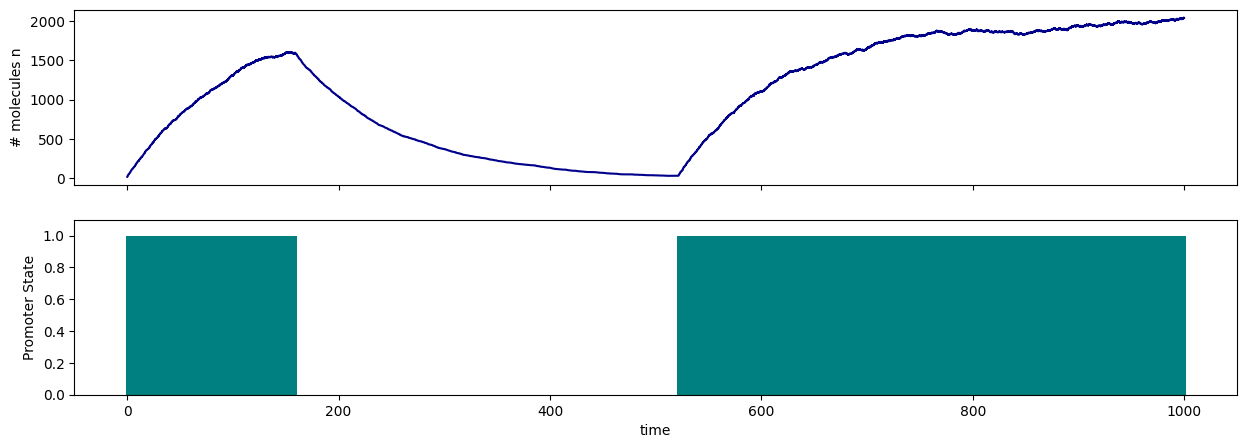

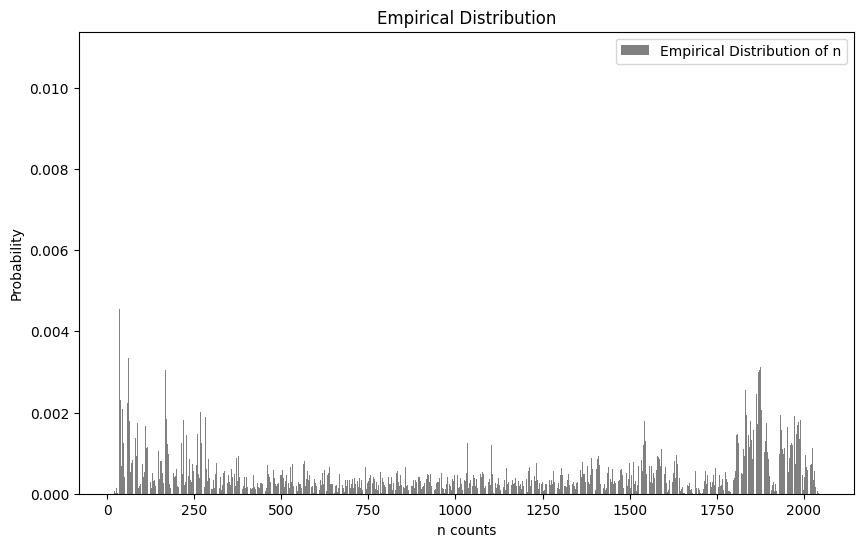

The value of k_off is 0.001 and the value of k_on is 0.06666666666666667


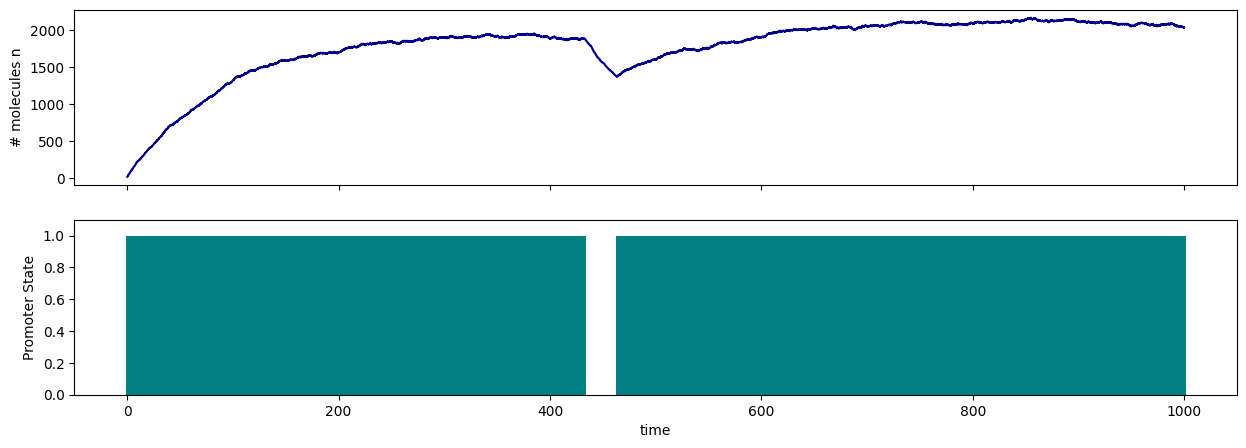

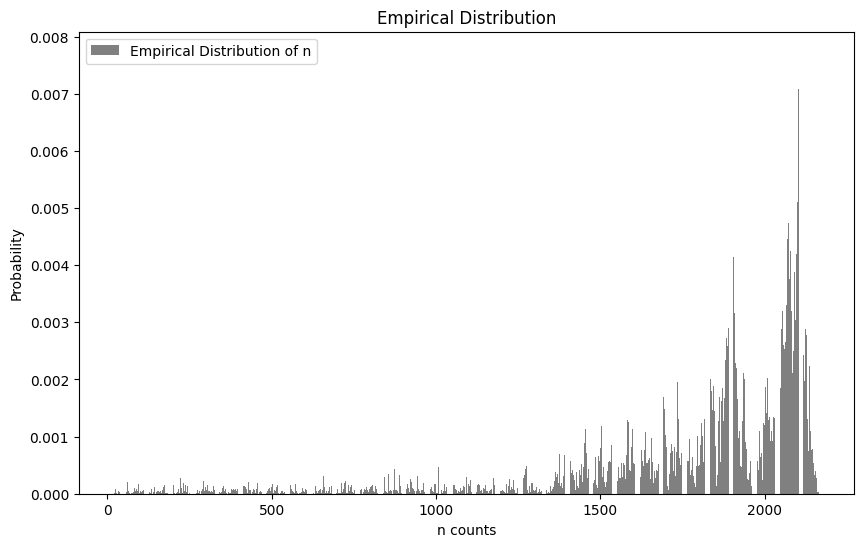

The value of k_off is 0.008333333333333333 and the value of k_on is 0.008333333333333333


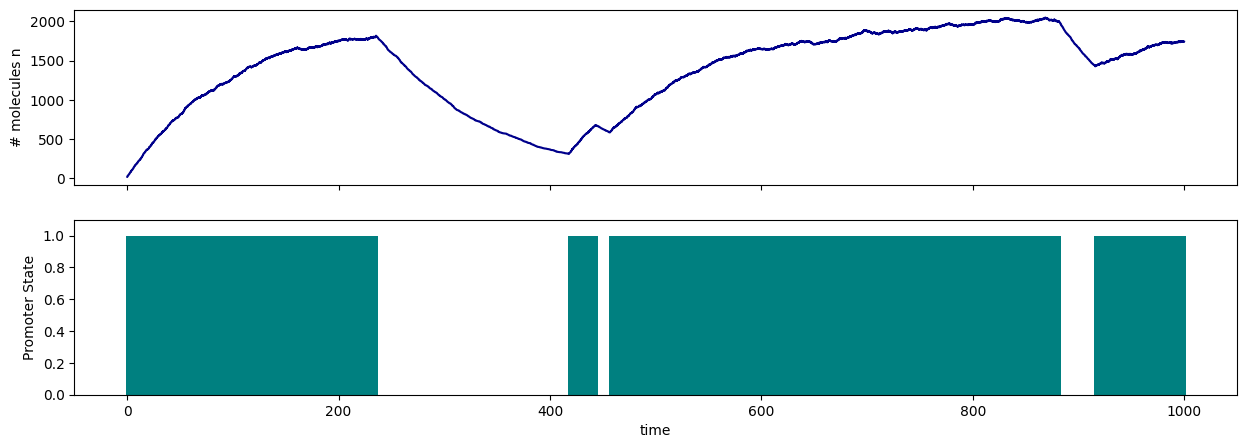

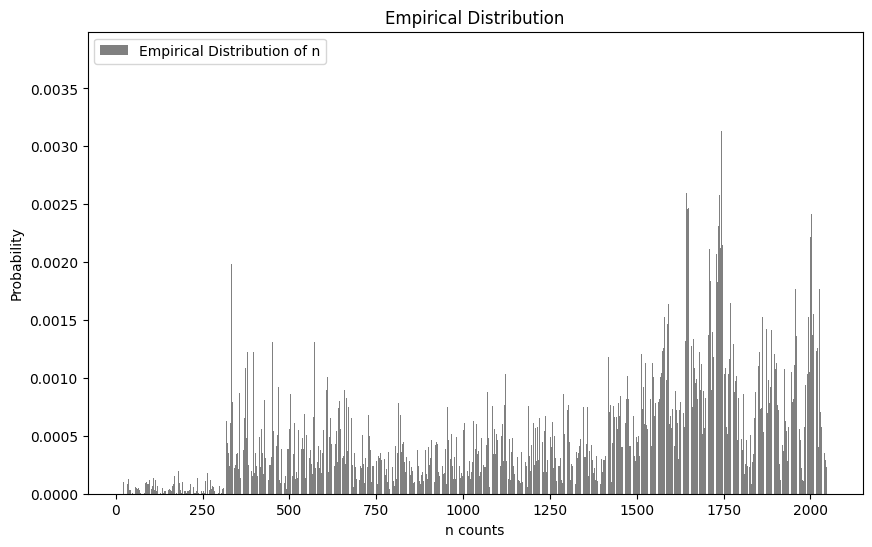

The value of k_off is 0.008333333333333333 and the value of k_on is 0.06666666666666667


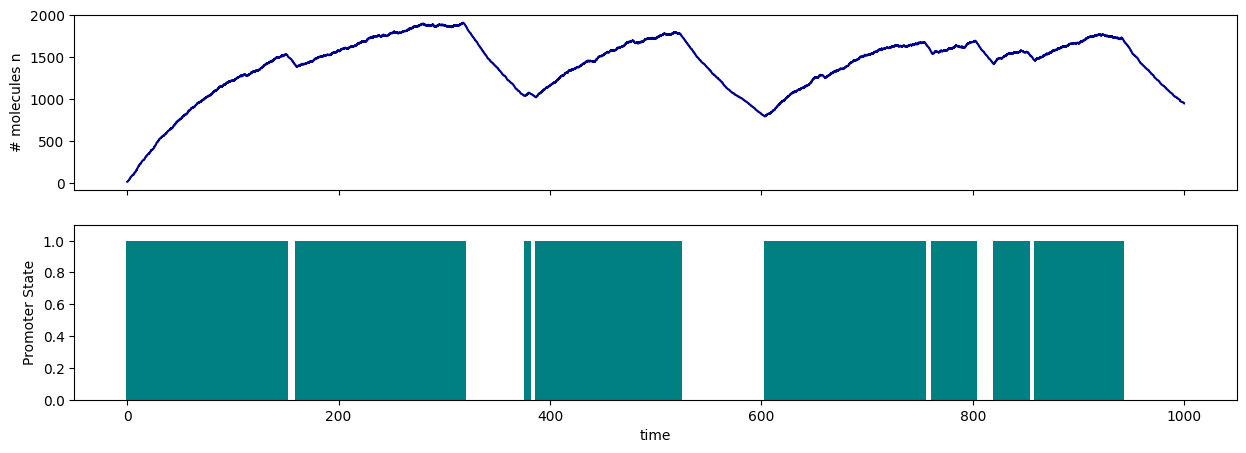

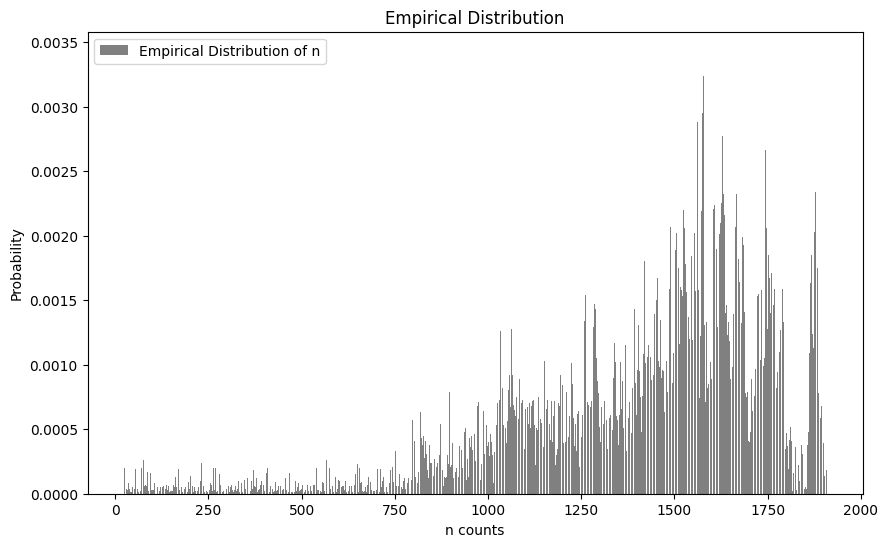

The value of k_off is 0.06666666666666667 and the value of k_on is 0.008333333333333333


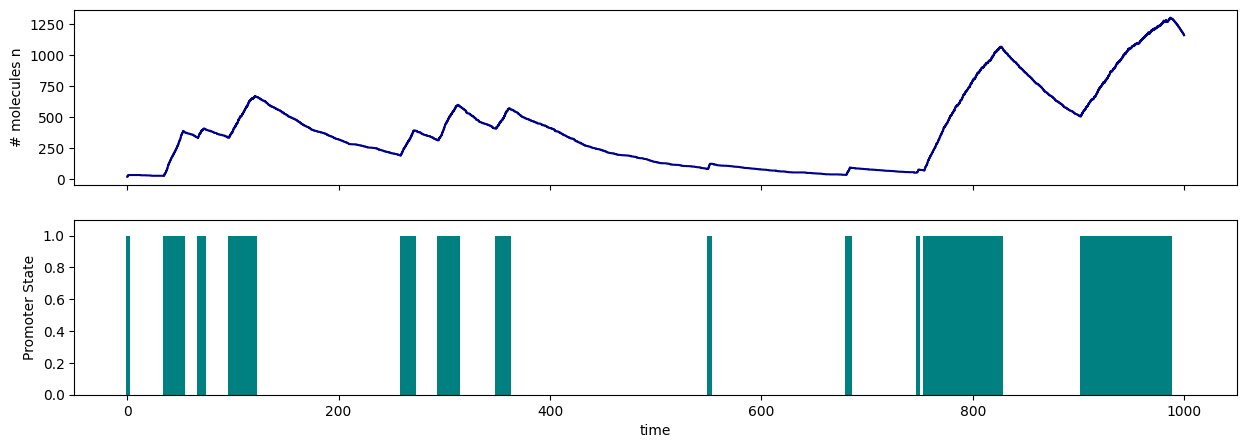

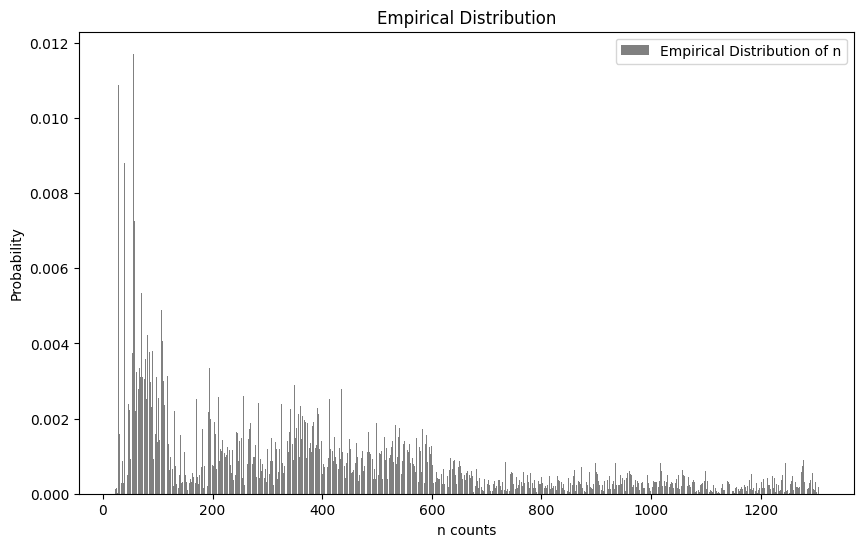

The value of k_off is 0.06666666666666667 and the value of k_on is 0.06666666666666667


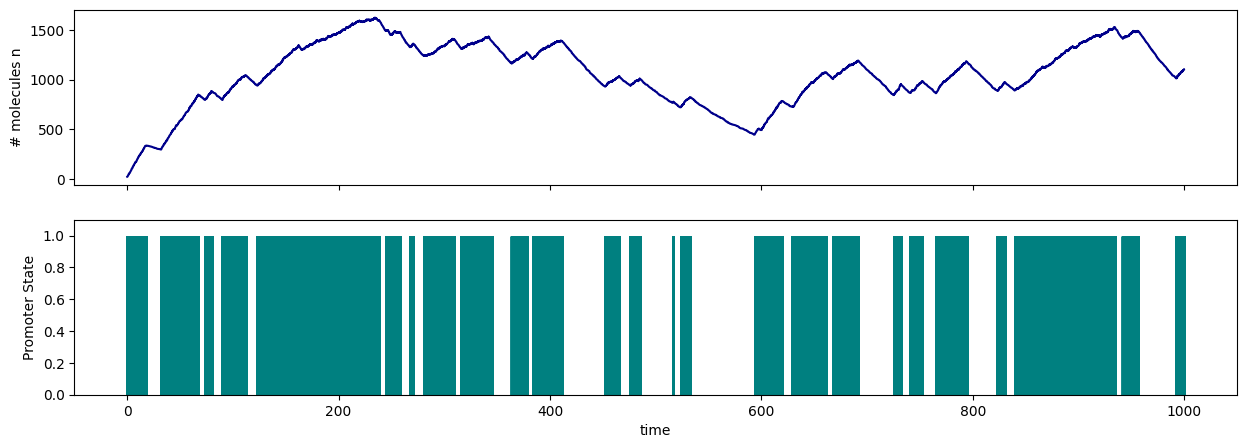

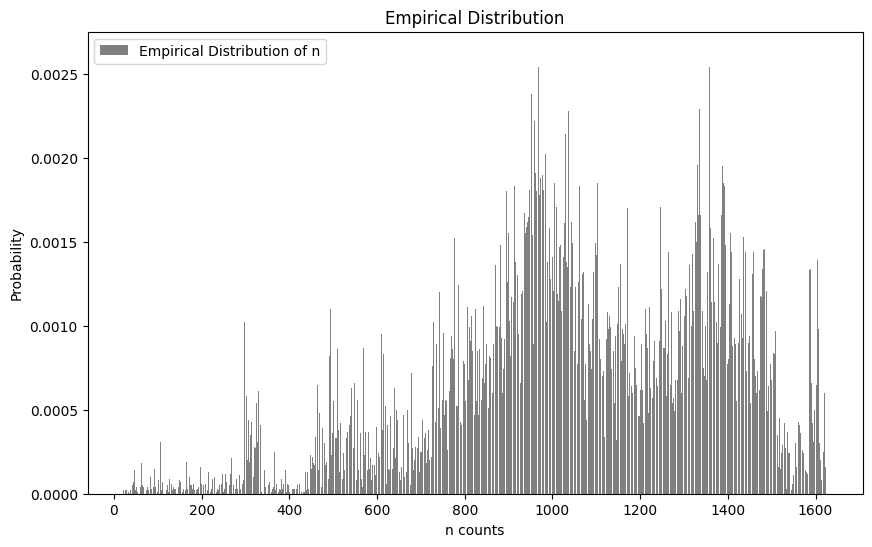

In [9]:
# Initial conditions for the state (g,n) at time t=0
g_0 = 1 # Initial promoter state
n_0 = 20 # Initial count of species n

DT = 0.01 # Time interval for returning/printing the output
t_end = 1000 #Total simulation time in minutes

#Parameters
s = 20 # Number of initiations per minute
k = 0.01 # Degradation rate, 1/k = 50 min
k_off_values = [1/1000, 1/120, 1/15] # Switching off rate, t_on = 1/k_off = 1000 min and 120 min and 15 min
k_on_values  = [1/120, 1/15] # Switching on rate, t_off = 1/k_on = 120 min and 1/k_on = 15 min

for k_off in k_off_values:
    for k_on in k_on_values:
        print(f'The value of k_off is {k_off} and the value of k_on is {k_on}')
        parameters = [s, k, k_on, k_off]

        # Run Gillespie simulation
        n, g, t = run_gillespie_telegraph(n_0, g_0, parameters, t_end, DT)

        # Plot the results
        plot_gillespie_telegraph(n, g, t)
        plot_histogram(n)


### Question 2
1. Study the distribution of mRNA numbers generated by your simulation. Identify a parameter regime that results in a Poisson distribution of mRNA numbers. Show the empiral histogram and overlay an exact Poisson distribution and comment.

2. Find parameters where the mRNA distribution deviates from the Poisson (e.g. a Negative Binomial distribution). Discuss why these changes lead to a different distribution. 

3. For parameters that yield an approximate Poisson distribution, discuss how the parameters of the Telegraph model relate to the parameters of the Poisson distributions. 

4. Show a set of parameters that leads to a bimodal distribution of mRNA numbers.  


####  Helper functions for the Poisson and Negative Binomal distributions

In [10]:
# Poisson distribution
def Poisson(lam, counts):
    """
    Calculate the Poisson distribution probability for given counts.
    
    Parameters:
    lam: The average number of events (rate parameter).
    counts: Observed counts.

    Returns:
    np.array: Probabilities corresponding to the observed counts.

    Notes:
    - This function uses the log-form of the Poisson probability mass function.
    - The gammaln function is used for calculating the logarithm of the factorial term.

    """

    logp = counts * np.log(lam) - lam - gammaln(counts + 1)
    return np.exp(logp)

# Negative Binomial distribution
# This may not be needed for the exercise, but it is included for completeness
def convert_params(mu, theta):
    """

    Convert mean and dispersion parameters to the shape and probability parameters of the negative binomial distribution.
    
    Parameters:
    mu: Mean of the distribution.
    theta: Dispersion parameter.

    Returns:
    tuple: Shape parameter (r) and success probability (p) of the negative binomial distribution.

    Notes
    - This conversion is necessary because different parameterizations are used in different contexts.

    """
    r = theta 
    var = mu + 1 / r * mu ** 2
    p = (var - mu) / var
    return r, 1 - p

def pmf_nb(counts, mu, theta): 
    """
    Compute the probability mass function of the negative binomial distribution for given counts.

    Parameters:
    counts: Observed counts.
    mu: Mean of the distribution.
    theta: Dispersion parameter.

    Returns:
    np.array: Probabilities corresponding to the observed counts.
    """
    

    return nbinom.pmf(counts, *convert_params(mu, theta))

#### Question 2.1-2.3: Gillespie Algorithm: Poisson Distribution Parameters

In [11]:
def plot_histogram_poisson(n, s, k):
    """
    Plots the distribution of data n with a superimposed Poisson distribution.

    Parameters:
    n: Array of counts (data from Gillespie simulation).
    s:synthesis rate
    k: decay rate

    """
    # Calculate histogram of n
    counts, bins = np.histogram(n, bins=range(min(n), max(n) + 2), density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])

    # Estimate lambda for Poisson distribution (mean of n)
    lam = s/k

    # Calculate Poisson probabilities for each bin center
    poisson_probs = Poisson(lam, bin_centers)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(bin_centers, counts, width=0.4, color='gray', label='Empirical Distribution of n')
    plt.plot(bin_centers, poisson_probs, marker='o', color='red', label='Poisson Distribution')

    plt.xlabel('n counts')
    plt.ylabel('Probability')
    plt.title('Empirical Distribution vs Poisson Distribution')
    plt.legend()
    plt.show()
    
def plot_histogram_poisson_mean(n):
    """
    Plots the distribution of data n with a superimposed Poisson distribution.

    Parameters:
    n: Array of counts (data from Gillespie simulation).

    """
    # Calculate histogram of n
    counts, bins = np.histogram(n, bins=range(min(n), max(n) + 2), density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])

    # Estimate lambda for Poisson distribution (mean of n)
    lam = np.mean(n)

    # Calculate Poisson probabilities for each bin center
    poisson_probs = Poisson(lam, bin_centers)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(bin_centers, counts, width=0.4, color='gray', label='Empirical Distribution of n')
    plt.plot(bin_centers, poisson_probs, marker='o', color='red', label='Poisson Distribution')

    plt.xlabel('n counts')
    plt.ylabel('Probability')
    plt.title('Empirical Distribution vs Poisson Distribution')
    plt.legend()
    plt.show()

To achieve a Poisson distribution, we need to have a simple birth-death process. 
In order to obtain the wanted distribution, we need to maintain an active promoter gene, which means having a small $k_{off}$ and a large $k_{on}$. In this scenario, the Poisson distribution will have a mean and variance of $\frac{s}{k}$.

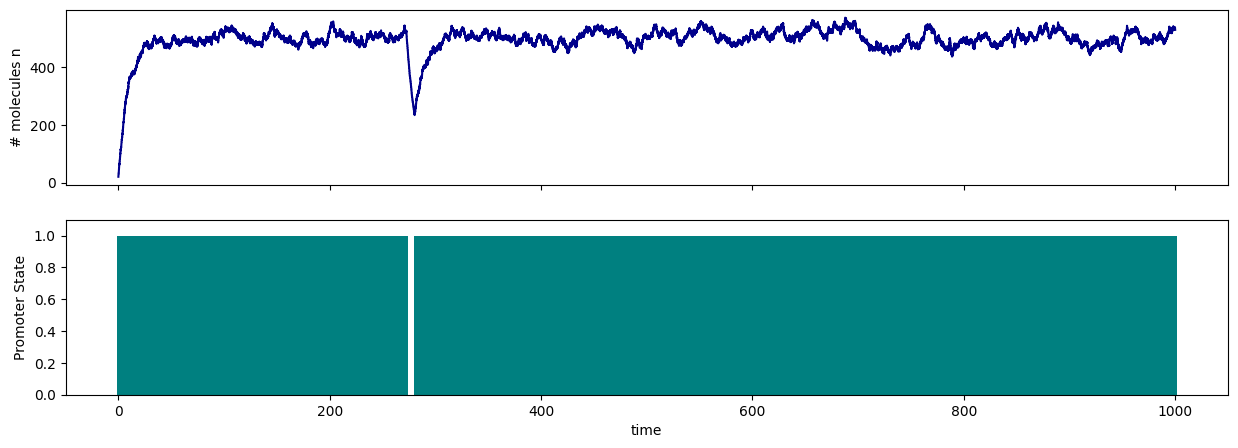

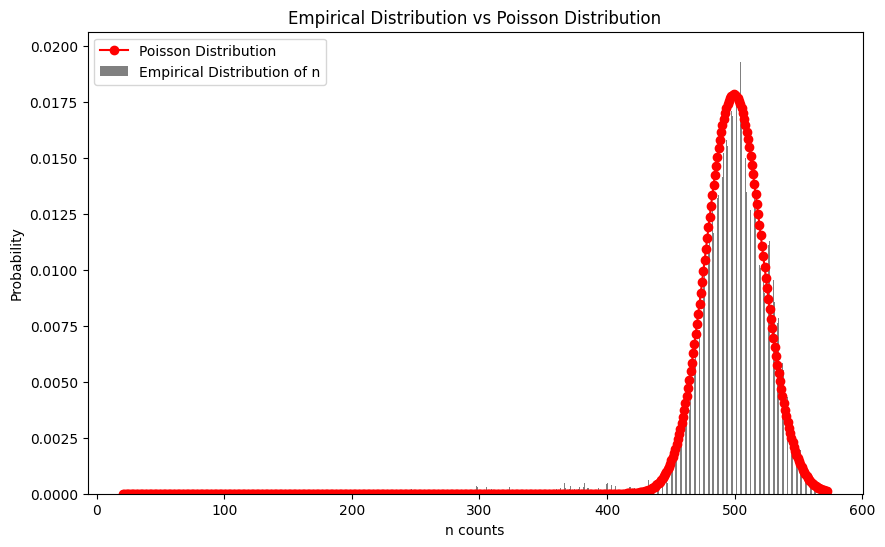

In [12]:
#initial conditions for the state (g,n) at time t=0
g_0 = 1 # Initial promoter state
n_0 = 20 # Initial count of species n

DT = 0.01 # Time interval for returning/printing the output
t_end = 1000 #Total simulation time in minutes

#Parameters
s = 50 # Number of initiations per minute
k = 0.1 # Degradation rate, 1/k = 50 min
k_off = 1/500 # Switching off rate, t_on = 1/k_off = 500 min
k_on  = 1/5 # Switching on rate, t_off = 1/k_on = 5 min

parameters = [s, k, k_on, k_off]

# Run Gillespie simulation
n, g, t = run_gillespie_telegraph(n_0, g_0, parameters, t_end, DT)

# Plot the results
plot_gillespie_telegraph(n, g, t)
plot_histogram_poisson(n, s, k)

#### Question 2.2: Gillespie Algorithm: Other Distribution

In order to obtain a distribution different from a Poissonian, we must prevent our distribution from oscillating around a given point for any extended period of time. In order to do this we have selected parameters k_on and k_off close to each other, leading to a greater number of oscillations in our distribution, as seen in the n-t plot. We made sure to select a degradation rate k that leads to a slow descent, in order to obtain significant concentration values different from zero. The low t_off (1/k_off) has been chosen to prevent the synthesis from reaching plateau value. By turning off the promoter gene before synthesis saturates, we can obtain a concentration probability descending the further away n is from zero.

A negative binomial distribution describes the probability of a certain number of failures in a sequence of independant Bernoulli trials. The two parameters are the probability of success p(r) and the number of successes r. In our case, we can model different r successes:
- $r_{off}$ : models the gene's state ie. if active at time t
- $r_{on}$ : models the gene's state ie. if inactive at time t
- $r_{deact}$ : similar to $k_{off}$
- $r_{act}$ : similar to $k_{on}$
- $r_{deg}$ : similar to s
- $r_{tran}$ : similar to k

When $r_{deact}$/$r_{deg}$ is very big, but $r_{on}$/$r_{deact}$ < 1, the probability distribution of mRNA converges to the negative binomial distribution. For our case, this basically means that:
1. the degradation rate should be very small compared to its deactivation rate ie. small s, big $k_{off}$
2. the deactivation rate should be bigger than the time for which the gene is on ie. big $k_{off}$, gene mostly off

It is difficult though to simulate an exact negative binomial because we do not know the exact relationship between our parameters and the one needed in the negative binomial (r, p(r)). 

In [13]:
def estimate_theta(n):
    """
    Estimate the parameter theta for the negative binomial distribution.

    Parameters:
    n: Counts array.

    Returns:
    theta: Estimation of the parameter theta.
    """
    mean = np.mean(n)
    var = np.var(n)

    theta = (var)
    
    return theta

def plot_histogram_negative_binomial(n, theta):
    """
    Plots the distribution of data n with a superimposed Negative Binomial distribution.

    Parameters:
    n: Array of counts (data from Gillespie simulation).
    theta: Dispersion parameter for the Negative Binomial distribution.
    """
    # Calculate histogram of n
    #returns counts (frequency of each value) and bins (edges of the intervals)
    counts, bins = np.histogram(n, bins=range(min(n), max(n) + 2), density=True) 
    
   
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    

    # Estimate mean for Negative Binomial distribution
    mu = np.mean(n)
    theta = np.var(counts)
    
    # Calculate Negative Binomial probabilities using pmf_nb function
    neg_binomial_probs = pmf_nb(counts, mu, theta)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(bin_centers, counts, width=0.8, color='gray', label='Empirical Distribution of n')
    plt.plot(bin_centers, neg_binomial_probs, marker='o', color='green', label='Negative Binomial Distribution')

    plt.xlabel('n counts')
    plt.ylabel('Probability')
    plt.title('Empirical Distribution vs Negative Binomial Distribution')
    plt.legend()
    plt.show()

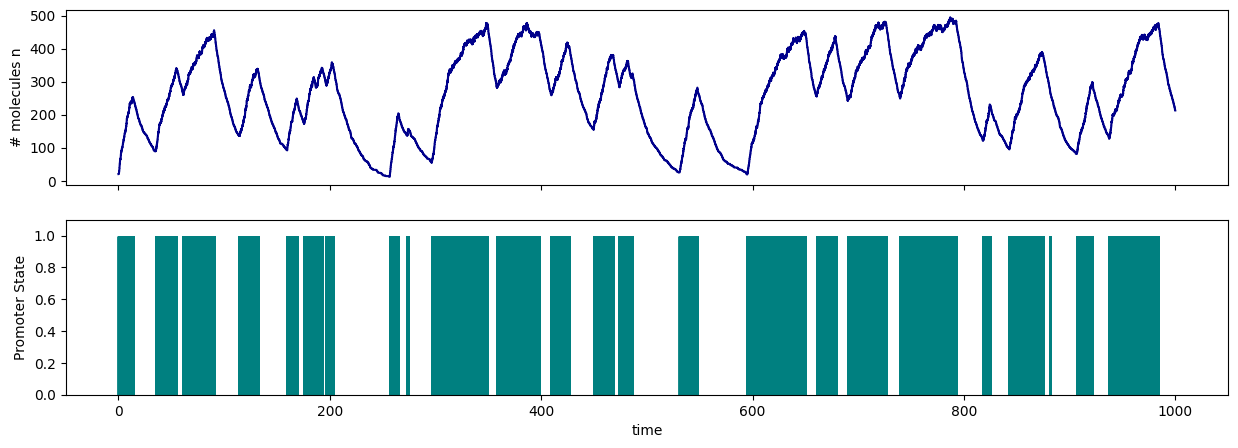

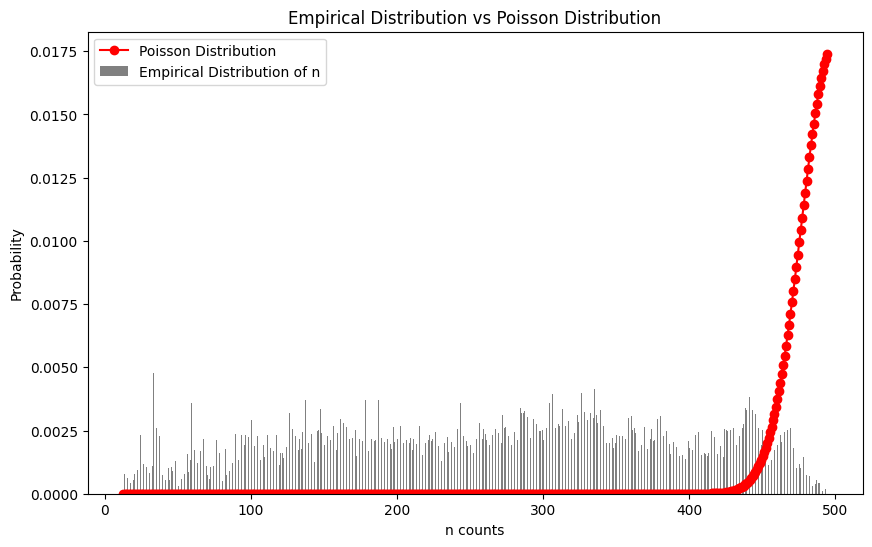

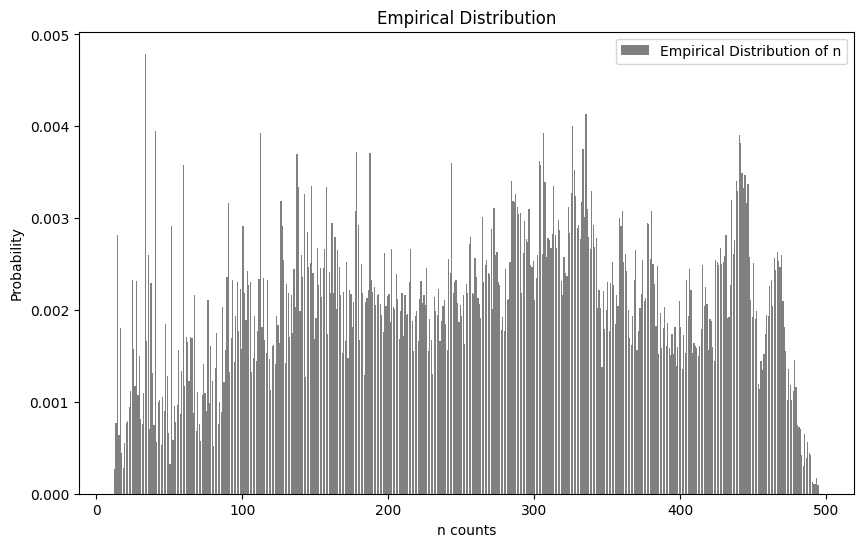

In [14]:
#initial conditions for the state (g,n) at time t=0
g_0 = 1 # Initial promoter state
n_0 = 20 # Initial count of species n

DT = 0.01 # Time interval for returning/printing the output
t_end = 1000 #Total simulation time in minutes

#Parameters
s = 25 # Number of initiations per minute
k = 1/20 # Degradation rate, 1/k = 50 min
k_off = 1/15 # Switching off rate, t_on = 1/k_off = 15 min
k_on  = 1/20 # Switching on rate, t_off = 1/k_on = 20 min

parameters = [s, k, k_on, k_off]

# Run Gillespie simulation 
n, g, t = run_gillespie_telegraph(n_0, g_0, parameters, t_end, DT)

# Plot the results
plot_gillespie_telegraph(n, g, t)
plot_histogram_poisson(n, s, k)
plot_histogram(n)

#### Question 2.4: Gillespie Algorithm: Bimodal Distribution

To obtain a bimodal ditribution, we have to choose parameters that allow our sitribution to oscillate around two different concentration levels 
To do this we have selected parameters that allow for a continuos ans steep descent between the plateau concentration (s/k = 1600 ) and zero.

To obtain a quick ascent and descent we've selected k with a high value (0.2) while to obtain a frequent promoter gent turn off-turn on, we have picked  large k_off and k_on, with k:off slightly smaller than k_on in order to keep the concentration oscillating around $n_{plateau}$ for an amount of time sufficient to highlight the peak centered around n=1600.

To limit the impact of the noise caused by the continuoos oscillation and better visualize the bimodal, we have added a second cell with a t_end increased tenfold, but equal parameters and initial condition.

What we expect at the end of this simulation is a bimodal distribution formed by the sum two poissonian peaks, one centered on $n_{plateau}$ and the other with central value of n == 0

Note the presence of a visualization quirk present in the first cell (ordinary t_end) caused by the implementation of the visualization methods of the binomial distribution. We have added two additional visualization that show the single Poissonian peaks mentioned in the previous paragraph.

In [24]:

def plot_with_bimodal_distribution(n, t_end):
    """
    Plots the empirical distribution of data n with a superimposed bimodal distribution.
    Parameters:
    n : Trajectory of species n counts over time.
    """
    
    n1 = n[( n< np.percentile(n,10) )]
    n1visual = n[(n< np.percentile(n,5))]
    if t_end ==1000:
        n2 = n[(n>=np.percentile(n,50))]
    else:
        n2 = n[(n>=np.percentile(n,40))]
    
    
    # Calculate histogram of n
    
    counts, bins = np.histogram(n, bins=range(min(n), max(n) + 2), density=True)
    counts1, bins1 = np.histogram(n1, bins=range(min(n1), max(n1) + 2), density=True)
    counts2, bins2 = np.histogram(n2, bins=range(min(n2), max(n2) + 2), density=True)
    
    print(len(counts), len(counts1), len(counts2))
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    bin_centers1 = 0.5*(bins1[1:] + bins1[:-1])
    bin_centers2 = 0.5*(bins2[1:] + bins2[:-1])
    
    lam1 = np.mean(n1)
    
    lam1visual = np.mean(n1visual)
    if lam1visual == 0:
        lam1visual = lam1visual + 0.1
    lam2 = np.mean(n2)
    lam = np.mean(n)


    # Calculate the bimodal distribution as a weighted sum of two Gaussian distributions
    Poisson1 = Poisson(lam1, bin_centers1)
    Poisson1visual = Poisson(lam1visual, bin_centers1)
    Poisson2 = Poisson(lam2, bin_centers2)
    print(Poisson1.shape, Poisson2.shape) #sanity check 
    bimodal = np.append(0.5*Poisson1, 0.5*Poisson2)
    print(bimodal.shape) #sanity check for the append, should be == Poisson1.shape + Poisson2.shape

    # Create a range of values for calculating the bimodal distribution
    values = np.linspace(min(n), max(n), bimodal.shape[0])
    values1 = np.linspace(min(n1),min(n1), Poisson1.shape[0])
    values2 = np.linspace(min(n2),min(n2), Poisson2.shape[0])
    
    #Plotting single poissonians
    #Poisson1
    plt.figure(figsize=(10, 6))
    plt.bar(bin_centers1, counts1, width=0.4, color='gray', label='Empirical Distribution of n')
    plt.plot(bin_centers1, Poisson1visual, marker='o', color='red', label='Poisson Distribution')

    plt.xlabel('n counts')
    plt.ylabel('Probability')
    plt.title('Empirical Distribution vs Poisson Distribution centered on n_plateau')
    plt.legend()
    plt.show()
    
    #Poisson2
    plt.figure(figsize=(10, 6))
    plt.bar(bin_centers2, counts2, width=0.4, color='gray', label='Empirical Distribution of n')
    plt.plot(bin_centers2, Poisson2, marker='o', color='red', label='Poisson Distribution')

    plt.xlabel('n counts')
    plt.ylabel('Probability')
    plt.title('Empirical Distribution vs Poisson Distribution centered on 0')
    plt.legend()
    plt.show()
    
    
    # Plotting bimodal
    plt.figure(figsize=(10, 6))
    plt.bar(bin_centers, counts, width=0.8, color='gray', label='Empirical Distribution of n')
    plt.plot(np.append(bin_centers1,bin_centers2), bimodal, color='red', label='Bimodal Distribution')
    #plt.plot(bin_centers1, Poisson1, color='blue', label='Posson1 Distribution') #Plots the distribution of n before the s change, and superimposes it with a Poisson distribution
    #plt.plot(bin_centers2, Poisson2, color='green', label='Poisson2 Distribution') #Plots the distribution of n after the s change, and superimposes it with a poisson distribution

    plt.xlabel('n counts')
    plt.ylabel('Probability Density')
    plt.title('Empirical Distribution vs Bimodal Distribution')
    plt.legend()
    plt.show()

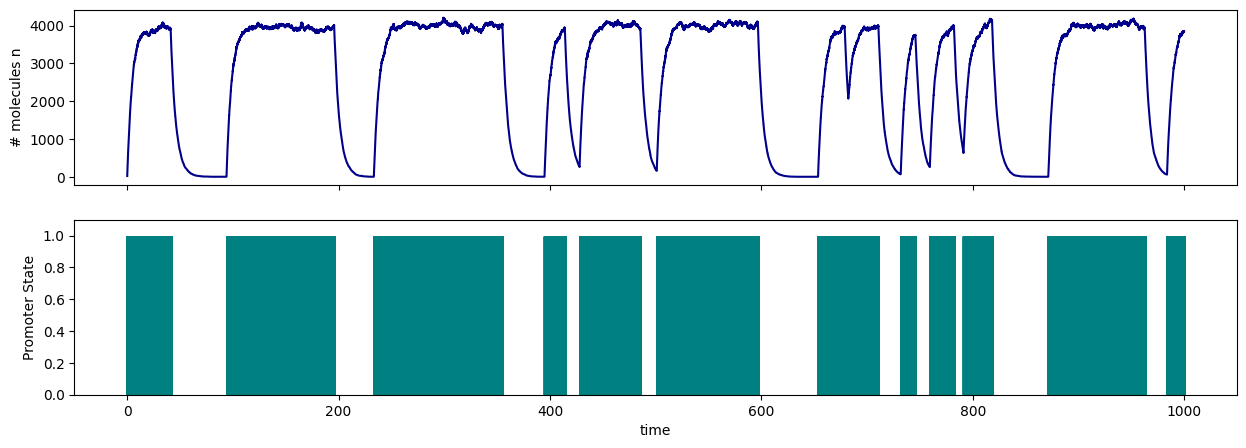

100000
4212 11 518
(11,) (518,)
(529,)


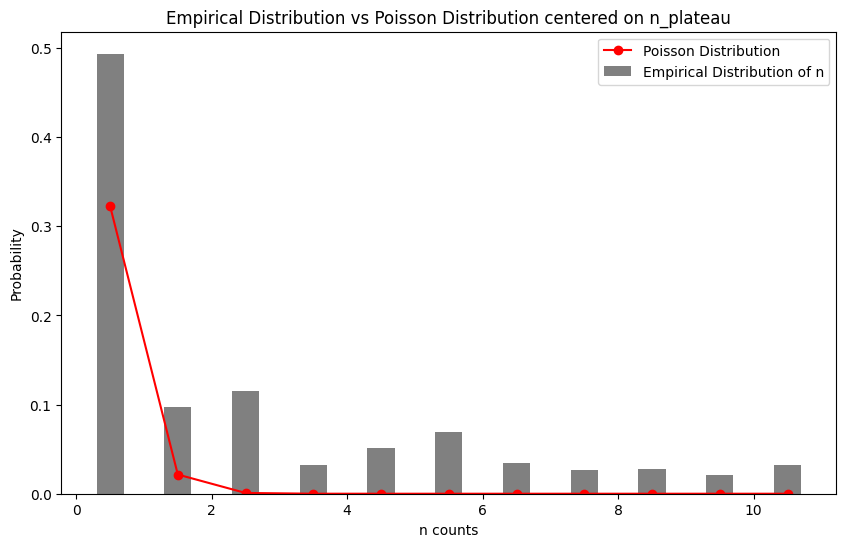

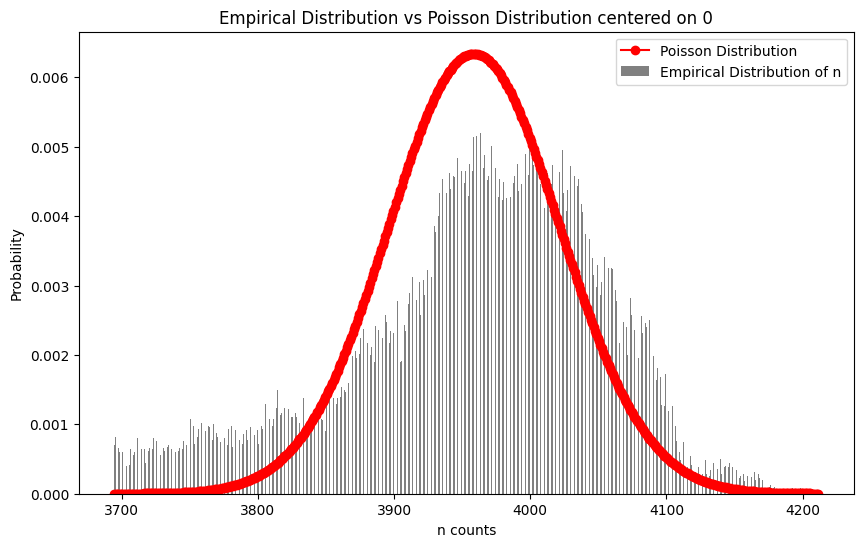

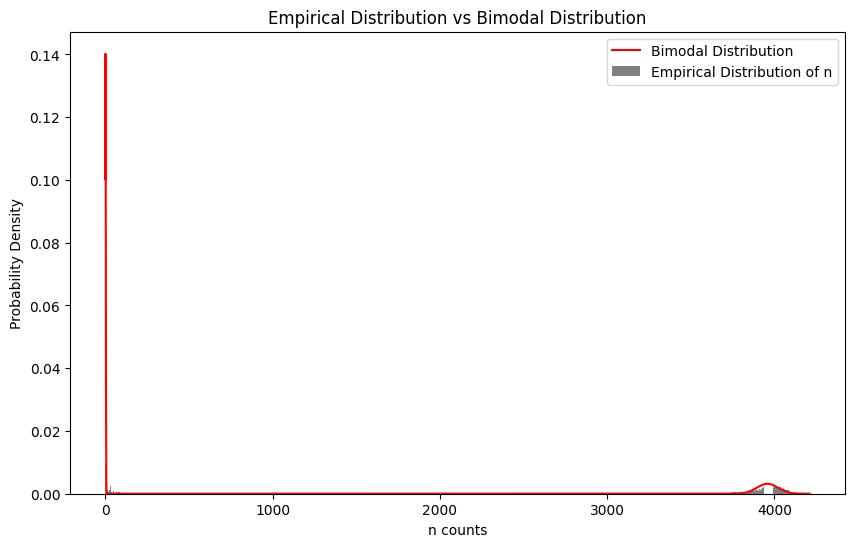

In [18]:
#initial conditions for the state (g,n) at time t=0
g_0 = 1 # Initial promoter state
n_0 = 20 # Initial count of species n

DT = 0.01 # Time interval for returning/printing the output
t_end = 1000 #Total simulation time in minutes

#Parameters
s = 800# Number of initiations per minute
k = 0.2# Degradation rate, t = 1/k = 5 min
k_off = 1/50#Switching off rate, t_on = 1/k_off = 50 min
k_on  = 1/20 #Switching on rate, t_off = 1/k_on = 20 min
parameters = [s, k, k_on, k_off]

# Run Gillespie simulation
n, g, t = run_gillespie_telegraph(n_0, g_0, parameters, t_end, DT)

# Plot the results
plot_gillespie_telegraph(n, g, t)
print(len(n))
n = np.asarray(n)
counts, bins = np.histogram(n, bins=range(min(n), max(n) + 2), density=True) 

plot_with_bimodal_distribution(n, t_end) #Plots the Bimodal Distribution of n as a sum of the Poissonian distribution of n1 and n2


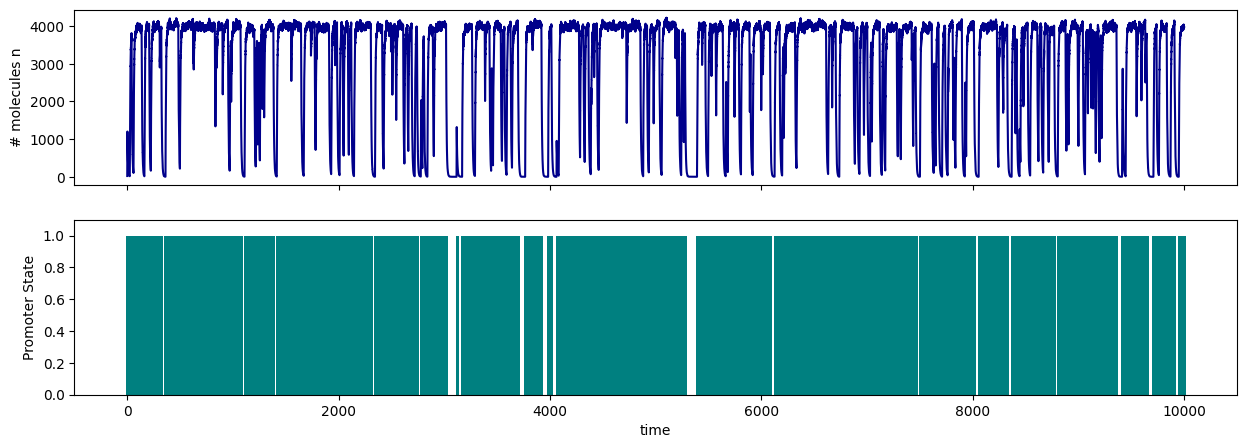

1000000
4227 142 547
(142,) (547,)
(689,)


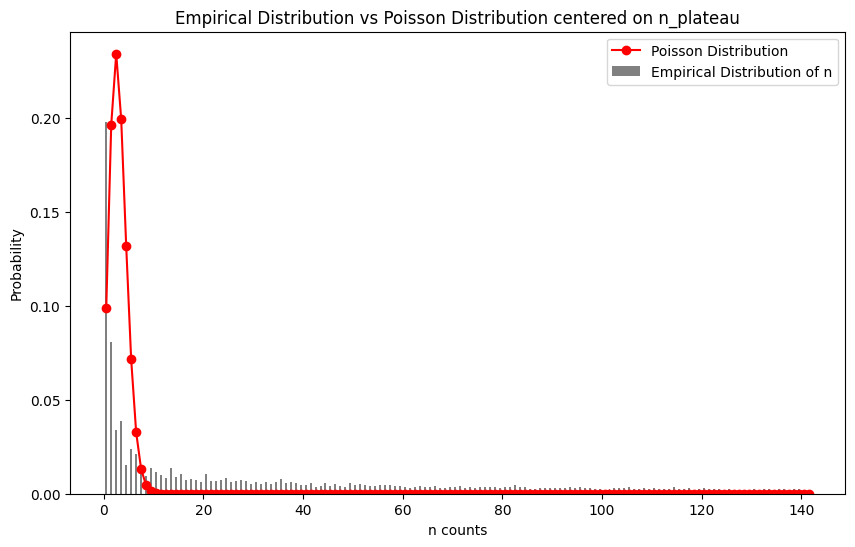

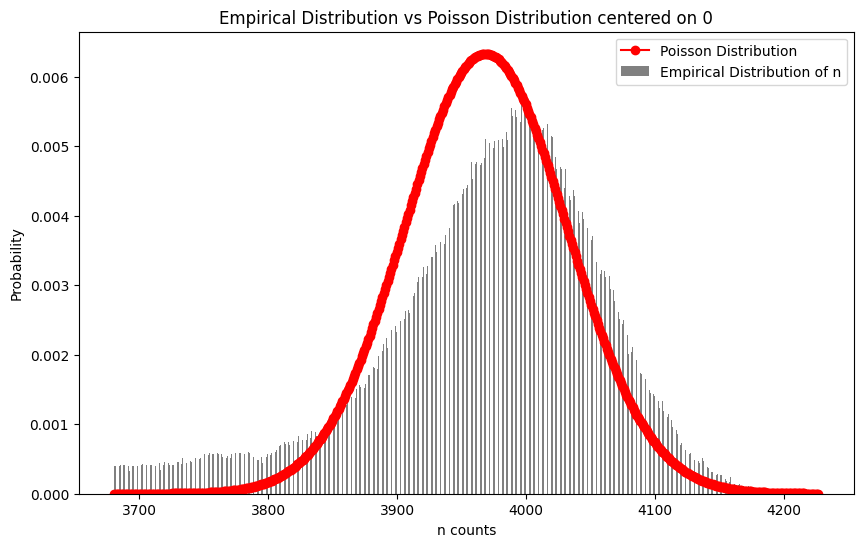

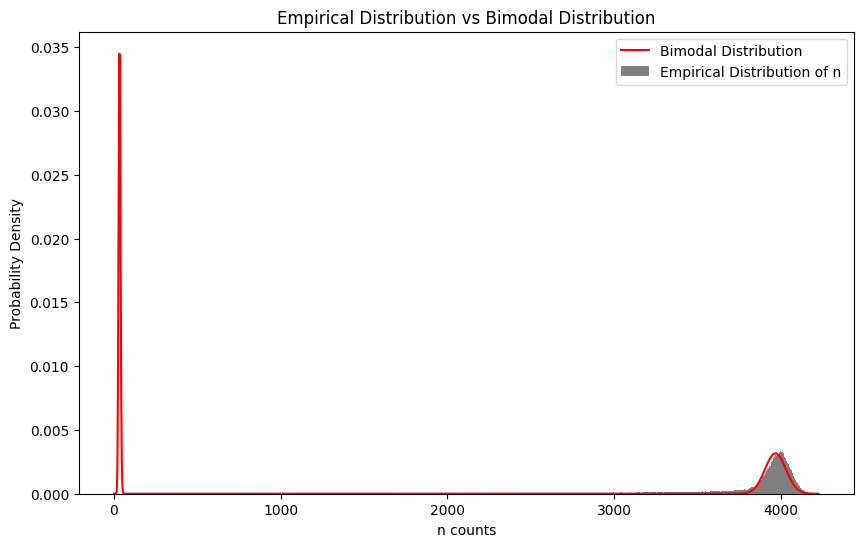

In [25]:
#initial conditions for the state (g,n) at time t=0
g_0 = 1 # Initial promoter state
n_0 = 20 # Initial count of species n

DT = 0.01 # Time interval for returning/printing the output
t_end = 10000 #Total simulation time in minutes

#Parameters
s = 800# Number of initiations per minute
k = 0.2# Degradation rate, 1/k = 5 min
k_off = 1/50#Switching off rate, t_on = 1/k_off = 50 min
k_on  = 1/20 #Switching on rate, t_off = 1/k_on = 20 min
parameters = [s, k, k_on, k_off]

# Run Gillespie simulation
n, g, t = run_gillespie_telegraph(n_0, g_0, parameters, t_end, DT)

# Plot the results
plot_gillespie_telegraph(n, g, t)
print(len(n))
n = np.asarray(n)
n1 = n[(n< np.percentile(n,10))]
n2 = n[(n>=np.percentile(n,50))]
counts, bins = np.histogram(n, bins=range(min(n), max(n) + 2), density=True) 

plot_with_bimodal_distribution(n, t_end) #Plots the Bimodal Distribution of n as a sum of the Poissonian distribution of n1 and n2
